In [2]:
!pip install wfdb neurokit2
# numpy, scipy, matplotlib are usually pre-installed

import wfdb
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import neurokit2 as nk
import os # For navigating paths
import random


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.5/696.5 kB 24.5 MB/s eta 0:00:00


In [3]:

TARGET_FS = 200  # Hz
# FILTER_LOWCUT = 0.5  # Hz (May not be needed if using pre-filtered signal)
# FILTER_HIGHCUT = 40.0  # Hz (May not be needed)
# FILTER_ORDER = 4

SEGMENT_SAMPLES = 1000 # Final segment length for CNN (e.g., 1000 samples @ 200Hz = 5 seconds)
R2R_P2T_PIECE_SAMPLES = 200 # Length of each piece before combining 5
NUM_PIECES_COMBINE = 5

NORM_MIN = -512
NORM_MAX = 512


In [4]:

# Base path for the dataset in Kaggle
BASE_DATA_PATH = '/kaggle/input/ecg-id/ecg-id-database-1.0.0/'

# Function to plot signals for inspection (same as before)
def plot_signal(signal, fs, title="Signal", x_label="Samples", y_label="Amplitude"):
    # If fs is None, it means the x-axis is already in samples
    if fs is not None:
        time_axis = np.arange(len(signal)) / fs
        x_input = time_axis
        if x_label == "Samples": # Default, but if fs provided, use time
             x_label_to_use = "Time (s)"
        else:
            x_label_to_use = x_label
    else:
        x_input = np.arange(len(signal))
        x_label_to_use = x_label

    plt.figure(figsize=(12, 4))
    plt.plot(x_input, signal)
    plt.title(title)
    plt.xlabel(x_label_to_use)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

In [5]:


def load_ecg_id_record(person_id_str, record_num_str, use_filtered=True):
    record_path_without_ext = os.path.join(BASE_DATA_PATH, person_id_str, record_num_str)
    print(f"Attempting to load record from: {record_path_without_ext}")
    try:
        # wfdb.rdsamp is returning a tuple: (signal_array, metadata_dict)
        returned_data = wfdb.rdsamp(record_path_without_ext)
        
        print(f"Type of object returned by wfdb.rdsamp: {type(returned_data)}")

        if not isinstance(returned_data, tuple) or len(returned_data) != 2:
            print("wfdb.rdsamp did not return the expected (signal, metadata) tuple.")
            return None, None

        signal_array = returned_data[0]  # The first element is the signal data
        metadata_dict = returned_data[1] # The second element is the metadata dictionary

        if use_filtered:
            # Ensure there are at least 2 columns if asking for column 1
            if signal_array.ndim == 1 or signal_array.shape[1] < 2 :
                print(f"Error: Requested filtered signal (column 1) but signal array has shape {signal_array.shape}")
                return None, None
            signal = signal_array[:, 1] 
            signal_type = "Filtered"
        else:
            signal = signal_array[:, 0] 
            signal_type = "Raw"
            
        fs = metadata_dict['fs'] # Get 'fs' from the metadata dictionary
        
        print(f"Loaded: {person_id_str}/{record_num_str} ({signal_type}), Original Fs: {fs} Hz, Signal length: {len(signal)}")
        return signal, fs # Return the selected signal column and fs
        
    except FileNotFoundError:
        print(f"Error: File not found for record {record_path_without_ext}")
        return None, None
    except Exception as e:
        print(f"General error loading record {record_path_without_ext}: {e}")
        import traceback
        traceback.print_exc()
        return None, None



Attempting to load record from: /kaggle/input/ecg-id/ecg-id-database-1.0.0/Person_01/rec_1
Type of object returned by wfdb.rdsamp: <class 'tuple'>
Loaded: Person_01/rec_1 (Filtered), Original Fs: 500 Hz, Signal length: 10000
Successfully loaded signal. Shape: (10000,), FS: 500


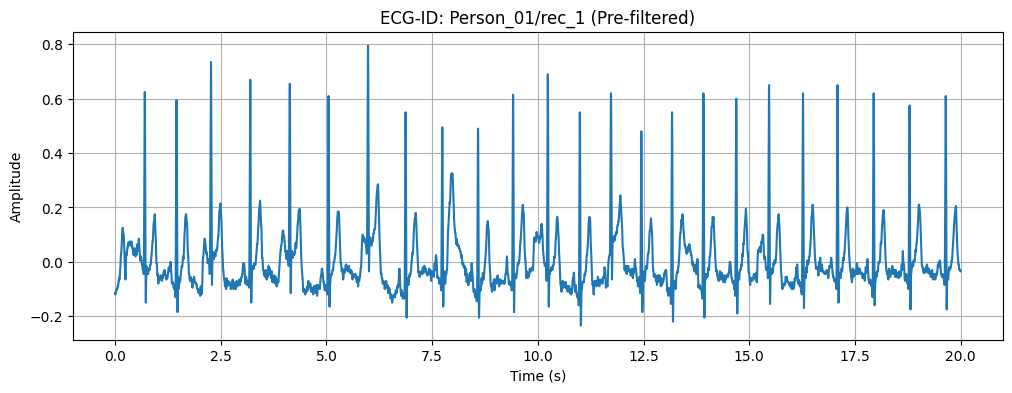

Final original_fs value: 500


In [6]:

person_id = 'Person_01'
record_num = 'rec_1'
ecg_signal, original_fs = load_ecg_id_record(person_id, record_num, use_filtered=True)

if ecg_signal is not None:
    print(f"Successfully loaded signal. Shape: {ecg_signal.shape}, FS: {original_fs}")
    plot_signal(ecg_signal, original_fs, title=f"ECG-ID: {person_id}/{record_num} (Pre-filtered)")
else:
    print("Failed to load signal (as determined by load_ecg_id_record return).")

print(f"Final original_fs value: {original_fs}")

In [10]:
import wfdb
import numpy as np
import scipy.signal as sig
# import matplotlib.pyplot as plt # Keep if needed for plotting intermediate steps
import neurokit2 as nk
import os
import random # Still useful for potential negative sampling logic later, or if you added randomization elsewhere

# --- Configuration Parameters (ensure these are defined and match your paper-based setup) ---
BASE_DATA_PATH = '/kaggle/input/ecg-id/ecg-id-database-1.0.0/' # Make sure this is correct for your environment
TARGET_FS = 200  # Hz - Target sampling rate after resampling
SEGMENT_SAMPLES = 1000 # Final segment length for CNN input
R2R_P2T_PIECE_SAMPLES = 200 # Length of individual P-T piece after resampling
NUM_PIECES_COMBINE = 5 # Number of P-T pieces to combine (5 * 200 = 1000)
NORM_MIN = -512
NORM_MAX = 512

MAX_ORIGINAL_R2R_PIECE_LEN = 400 # samples (at TARGET_FS) - Filter out very long RR intervals

# --- Helper Function Definitions (Copy/Ensure these are here and correct) ---
# plot_signal (Optional)
# load_ecg_id_record

def plot_signal(signal, fs, title="Signal", x_label="Samples", y_label="Amplitude"):
    if fs is not None:
        time_axis = np.arange(len(signal)) / fs
        x_input = time_axis
        x_label_to_use = "Time (s)" if x_label == "Samples" else x_label
    else:
        x_input = np.arange(len(signal))
        x_label_to_use = x_label

    plt.figure(figsize=(12, 4))
    plt.plot(x_input, signal)
    plt.title(title)
    plt.xlabel(x_label_to_use)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

def resample_signal(signal, original_fs, target_fs):
    # Added print statements for better debugging
    if original_fs == target_fs:
        # print("Signal already at target frequency.") # Removed to reduce log spam
        return signal
    if signal is None or len(signal) == 0:
        print("Cannot resample an empty signal.")
        return np.array([])
    num_samples_target = int(len(signal) * target_fs / original_fs)
    if num_samples_target < 1 :
        # print(f"Target samples for resampling is {num_samples_target}, too small. Original len: {len(signal)}") # Removed to reduce log spam
        return np.array([])
    try:
        resampled_signal = sig.resample(signal, num_samples_target)
        # print(f"Resampled signal from {original_fs} Hz to {target_fs} Hz. New length: {len(resampled_signal)}") # Removed to reduce log spam
        return resampled_signal
    except Exception as e:
        print(f"Error during resampling: {e}")
        return np.array([])


def normalize_segment(segment, min_val=NORM_MIN, max_val=NORM_MAX):
    seg_min, seg_max = np.min(segment), np.max(segment)
    if seg_max == seg_min: return np.full_like(segment, (min_val + max_val) / 2.0)
    normalized = (segment - seg_min) / (seg_max - seg_min)
    normalized = normalized * (max_val - min_val) + min_val
    return normalized

def bandpass_filter(signal, fs, lowcut=0.5, highcut=40):
    """
    Applies a bandpass filter to the signal.
    """
    if signal is None or len(signal) == 0: return np.array([])
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Handle edge cases for cutoff frequencies
    if low >= high:
        # print(f"Warning: Low cutoff ({lowcut}) >= High cutoff ({highcut}). Returning empty array.")
        return np.array([])
    if low >= 1.0: # Low cutoff above Nyquist
        # print(f"Warning: Low cutoff ({lowcut}) >= Nyquist ({nyquist}). Returning empty array.")
        return np.array([])
    if high >= 1.0: # High cutoff above Nyquist
         high = 0.99 # Set to just below Nyquist

    # Using a Butterworth filter, order can be adjusted
    order = 5
    try:
        b, a = sig.butter(order, [low, high], btype='band')
        # Apply filter forward and backward to avoid phase distortion
        filtered_signal = sig.filtfilt(b, a, signal)
        return filtered_signal
    except ValueError as e:
         print(f"Filtering error: {e}")
         return np.array([])
    except np.linalg.LinAlgError as e:
         print(f"Filtering LinAlg error: {e}")
         return np.array([])
    except Exception as e:
         print(f"An unexpected filtering error occurred: {e}")
         return np.array([])


# --- R2R Segmentation Function (NEW) ---
def segment_r2r(signal, fs, target_piece_samples=R2R_P2T_PIECE_SAMPLES, num_pieces=NUM_PIECES_COMBINE, max_original_piece_len=MAX_ORIGINAL_R2R_PIECE_LEN):
    """
    Segments ECG signal based on R-peak to R-peak intervals,
    filters by original length, resamples pieces, and combines consecutive pieces.
    """
    final_segments = []
    
    # Need enough data for R-peak detection and at least NUM_PIECES_COMBINE beats
    # A typical HR is 60 bpm (1 beat/sec). 5 beats is 5 seconds. At 200Hz, 5 seconds is 1000 samples.
    # So need at least SEGMENT_SAMPLES (1000) worth of signal approximately.
    if signal is None or len(signal) < SEGMENT_SAMPLES:
        # print(f"  segment_r2r: Input signal too short ({len(signal)} samples) for segmentation.")
        return final_segments

    # 1. Detect R-peaks
    try:
        _, rpeaks = nk.ecg_peaks(signal, sampling_rate=fs)
        rpeaks = rpeaks['ECG_R_Peaks']
        # Remove first/last R-peak if they are too close to signal start/end? Or let piece extraction handle?
        # Let's just use all detected R-peaks for now.
        
        if len(rpeaks) < num_pieces + 1: # Need at least 6 R-peaks to get 5 consecutive R-R intervals
             # print(f"  segment_r2r: Not enough R-peaks ({len(rpeaks)}) to form at least one {num_pieces}-piece segment.")
             return final_segments

    except Exception as e:
        # print(f"  segment_r2r: Error during neurokit2 R-peak detection: {e}")
        return final_segments

    # 2. Extract, Filter by Length, and Resample R-R Pieces
    rr_pieces_resampled = []

    # Iterate through consecutive R-peak indices (R[i] to R[i+1])
    for i in range(len(rpeaks) - 1):
        r1_idx = rpeaks[i]
        r2_idx = rpeaks[i+1]

        # Extract the piece between R1 and R2
        piece = signal[r1_idx : r2_idx]

        # Check original piece length (filter out excessively long segments, likely due to missed peaks)
        if len(piece) > 0 and len(piece) <= max_original_piece_len:
            # Resample the accepted piece to the target piece length
            resampled_piece = sig.resample(piece, target_piece_samples)

            # Check if resampling was successful and resulted in the correct size
            if len(resampled_piece) == target_piece_samples:
                rr_pieces_resampled.append(resampled_piece)
            # else: print(f"  segment_r2r: Resampling piece from {len(piece)} to {target_piece_samples} failed.")
        # else:
            # print(f"  segment_r2r: Skipping R-R piece from index {r1_idx} to {r2_idx}. Original length {len(piece)} samples (Limit: {max_original_piece_len}).")


    # print(f"  segment_r2r: Extracted, filtered, and resampled {len(rr_pieces_resampled)} valid R-R pieces (each {target_piece_samples} samples).")

    # 3. Combine Consecutive Pieces
    if len(rr_pieces_resampled) < num_pieces:
        # print(f"  segment_r2r: Not enough valid R-R pieces ({len(rr_pieces_resampled)}) to form any {num_pieces}-piece segments.")
        return final_segments # Cannot form any 5-piece segments

    # Iterate through the resampled pieces and combine consecutive groups
    for i in range(len(rr_pieces_resampled) - num_pieces + 1):
        combined_segment = np.concatenate(rr_pieces_resampled[i : i + num_pieces])
        
        # Check if concatenation yielded correct length (5*200)
        if len(combined_segment) == num_pieces * target_piece_samples:
             final_segments.append(combined_segment)
        # else: print(f"  segment_r2r: Combined segment has incorrect length {len(combined_segment)}. Expected {num_pieces * target_piece_samples}")


    # print(f"  segment_r2r: Formed {len(final_segments)} final {SEGMENT_SAMPLES}-sample segments.")

    return final_segments



In [11]:

# --- P2T Segmentation Function (NEW) ---
def segment_p2t(signal, original_fs, target_fs=TARGET_FS, piece_samples=R2R_P2T_PIECE_SAMPLES, num_pieces=NUM_PIECES_COMBINE):
    """
    Segments ECG signal based on P-peak to T-peak intervals,
    resamples pieces, and combines consecutive pieces.
    """
    final_segments = []
    
    if signal is None or len(signal) < target_fs: # Need at least 1 second of data to find peaks
        return final_segments

    # 1. Bandpass Filter (assuming the input 'signal' is already filtered from the main loop, but let's filter again defensively if needed)
    # For this setup, we assume the input 'signal' here is already the bandpass-filtered, resampled signal at target_fs.
    # So we don't need to filter/resample *inside* this function.
    # signal_processed = bandpass_filter(signal, target_fs) # Assuming signal is already filtered at target_fs
    # signal_processed = resample_signal(signal_processed, original_fs, target_fs) # Assuming signal is already resampled

    signal_processed = signal # Use the input signal directly, assuming it's ready
    fs = target_fs # Use the target_fs

    if signal_processed is None or len(signal_processed) == 0:
        print("  segment_p2t: Input signal is empty after assumed preprocessing.")
        return final_segments

    # 2. Detect Peaks and Delineate
    try:
        # Find R-peaks
        _, rpeaks = nk.ecg_peaks(signal_processed, sampling_rate=fs)
        rpeaks = rpeaks['ECG_R_Peaks']
        if len(rpeaks) < num_pieces:
             # print(f"  segment_p2t: Not enough R-peaks ({len(rpeaks)}) to form at least one {num_pieces}-piece segment.")
             return final_segments

        # Delineate waves (P, Q, R, S, T) based on R-peaks
        # Use 'wavelet' method as suggested by paper's reference [32]
        delineate_signal, waves = nk.ecg_delineate(signal_processed, rpeaks, sampling_rate=fs, method="wavelet")

        # Extract peak locations for P and T
        p_peaks = waves['ECG_P_Peaks']
        t_peaks = waves['ECG_T_Peaks']
        
        # Check if delineation was successful enough
        if p_peaks is None or t_peaks is None or len(p_peaks) == 0 or len(t_peaks) == 0:
             # print("  segment_p2t: Delineation failed to find P or T peaks.")
             return final_segments

    except Exception as e:
        # print(f"  segment_p2t: Error during neurokit2 processing: {e}")
        return final_segments

    # 3. Extract and Resample P-T Pieces
    pt_pieces_resampled = []
    
    # We need to align P, T peaks with corresponding R-peaks
    # Neurokit2's delineation usually aligns waves to the nearest R-peak index
    # Let's iterate through R-peaks and find the corresponding P and T within a reasonable window
    
    # Helper to find nearest peak index within a range
    def find_nearest_peak(peak_list, anchor_idx, search_range_samples):
        if peak_list is None or len(peak_list) == 0: return None
        search_min = max(0, anchor_idx - search_range_samples)
        search_max = min(len(signal_processed) - 1, anchor_idx + search_range_samples)
        
        valid_peaks_in_range = [p for p in peak_list if search_min <= p <= search_max]
        if not valid_peaks_in_range: return None
        
        # Find the closest one
        closest_peak = min(valid_peaks_in_range, key=lambda p: abs(p - anchor_idx))
        return closest_peak if abs(closest_peak - anchor_idx) <= search_range_samples else None

    
    max_pr_interval_samples = int(0.3 * fs) # e.g., 300ms before R
    max_rt_interval_samples = int(0.5 * fs) # e.g., 500ms after R

    valid_pieces_indices = [] # Store (start_idx, end_idx) of the extracted P-T pieces

    for r_idx in rpeaks:
        # Find the P-peak closest before R
        p_idx = find_nearest_peak([p for p in p_peaks if p < r_idx], r_idx, max_pr_interval_samples)
        
        # Find the T-peak closest after R
        t_idx = find_nearest_peak([t for t in t_peaks if t > r_idx], r_idx, max_rt_interval_samples)
        
        # Check if both P and T were found and the P-T interval is valid (P before T)
        if p_idx is not None and t_idx is not None and p_idx < t_idx:
            
            piece = signal_processed[p_idx : t_idx + 1] # Include T-peak sample
            if len(piece) > 0:
                 # Resample the piece
                 resampled_piece = sig.resample(piece, piece_samples)
                 if len(resampled_piece) == piece_samples:
                     # Store the resampled piece
                     pt_pieces_resampled.append(resampled_piece)
                 # else: print(f"  segment_p2t: Resampling piece from {len(piece)} to {piece_samples} failed.")
            # else: print(f"  segment_p2t: Extracted P-T piece was empty (p_idx={p_idx}, t_idx={t_idx}).")
        # else: print(f"  segment_p2t: Could not find valid P-T pair around R-peak at index {r_idx}.")


    # print(f"  segment_p2t: Extracted and resampled {len(pt_pieces_resampled)} valid P-T pieces (each {piece_samples} samples).")

    # 4. Combine Consecutive Pieces
    if len(pt_pieces_resampled) < num_pieces:
        # print(f"  segment_p2t: Not enough valid P-T pieces ({len(pt_pieces_resampled)}) to form any {num_pieces}-piece segments.")
        return final_segments # Cannot form any 5-piece segments

    # Iterate through the resampled pieces and combine consecutive groups
    for i in range(len(pt_pieces_resampled) - num_pieces + 1):
        combined_segment = np.concatenate(pt_pieces_resampled[i : i + num_pieces])
        if len(combined_segment) == segment_samples: # Check if concatenation yielded correct length (5*200)
             final_segments.append(combined_segment)
        # else: print(f"  segment_p2t: Combined segment has incorrect length {len(combined_segment)}. Expected {segment_samples}")

    # print(f"  segment_p2t: Formed {len(final_segments)} final {segment_samples}-sample segments.")

    return final_segments




In [12]:

# --- Data Storage ---
all_processed_segments = []
source_ids_list = [] # Storing source_ids separately

# --- MODIFIED LIMITS and Segmentation Method ---
# Keep your previous limits here for consistency with the amount of data you processed
MAX_PERSONS_TO_PROCESS = 90 # Process up to 90 persons
# No MAX_RECORDS_PER_PERSON limit is used in your code
# We will extract ALL possible valid R2R segments from each record

print("--- Starting Dataset-Wide Preprocessing (R2R Segmentation) ---")

person_folders = sorted([d for d in os.listdir(BASE_DATA_PATH) if os.path.isdir(os.path.join(BASE_DATA_PATH, d)) and d.startswith('Person_')])

persons_processed_count = 0
for person_folder_name in person_folders:
    if persons_processed_count >= MAX_PERSONS_TO_PROCESS:
        print(f"Reached MAX_PERSONS_TO_PROCESS limit ({MAX_PERSONS_TO_PROCESS}). Stopping person loop.")
        break

    # print(f"\nProcessing {person_folder_name} ({persons_processed_count+1}/{MAX_PERSONS_TO_PROCESS})...") # Too verbose
    person_path = os.path.join(BASE_DATA_PATH, person_folder_name)

    record_base_names = sorted(list(set([f.split('.')[0] for f in os.listdir(person_path) if f.startswith('rec_') and f.endswith('.dat')])))

    # No MAX_RECORDS_PER_PERSON limit here
    record_count_for_person = 0
    for rec_idx, rec_base_name in enumerate(record_base_names):
        # print(f"  Loading record: {rec_base_name} ({rec_idx+1}/{len(record_base_names)} for this person)...") # Too verbose

        # Load the raw signal first
        raw_ecg_signal, original_fs = load_ecg_id_record(person_folder_name, rec_base_name, use_filtered=False) # Use raw for filtering

        if raw_ecg_signal is not None and original_fs is not None:
            # Apply bandpass filter *before* resampling for better peak detection
            filtered_ecg = bandpass_filter(raw_ecg_signal, original_fs)

            # Resample the filtered signal to TARGET_FS
            resampled_filtered_ecg = resample_signal(filtered_ecg, original_fs, TARGET_FS)

            # Perform R2R segmentation on the resampled and filtered signal
            final_segments = segment_r2r(resampled_filtered_ecg, fs=TARGET_FS, target_piece_samples=R2R_P2T_PIECE_SAMPLES, num_pieces=NUM_PIECES_COMBINE, max_original_piece_len=MAX_ORIGINAL_R2R_PIECE_LEN)

            if len(final_segments) > 0:
                 current_segment_count = 0
                 for seg in final_segments:
                    # Normalize each final 1000-sample segment
                    norm_seg = normalize_segment(seg, NORM_MIN, NORM_MAX)
                    source_id = (person_folder_name, rec_base_name)
                    all_processed_segments.append(norm_seg)     # Store segment
                    source_ids_list.append(source_id)         # Store corresponding source_id
                    current_segment_count += 1
                 # print(f"    Stored {current_segment_count} segments from {person_folder_name}/{rec_base_name}") # Too verbose
                 record_count_for_person += 1 # Count records that yielded segments

            # else: print(f"    Skipping {rec_base_name}: No valid R2R segments could be formed.") # Too verbose

        # else: print(f"    Skipping {rec_base_name} due to loading failure.") # Too verbose

    if record_count_for_person > 0:
         print(f"\nProcessed {person_folder_name} (from {record_count_for_person} records).") # Summarize per person

    persons_processed_count += 1

print(f"\n--- Finished Preprocessing (R2R Segmentation) ---")
print(f"Total processed segments stored: {len(all_processed_segments)}")



--- Starting Dataset-Wide Preprocessing (R2R Segmentation) ---
Attempting to load record from: /kaggle/input/ecg-id/ecg-id-database-1.0.0/Person_01/rec_1
Type of object returned by wfdb.rdsamp: <class 'tuple'>
Loaded: Person_01/rec_1 (Raw), Original Fs: 500 Hz, Signal length: 10000
Attempting to load record from: /kaggle/input/ecg-id/ecg-id-database-1.0.0/Person_01/rec_10
Type of object returned by wfdb.rdsamp: <class 'tuple'>
Loaded: Person_01/rec_10 (Raw), Original Fs: 500 Hz, Signal length: 10000
Attempting to load record from: /kaggle/input/ecg-id/ecg-id-database-1.0.0/Person_01/rec_11
Type of object returned by wfdb.rdsamp: <class 'tuple'>
Loaded: Person_01/rec_11 (Raw), Original Fs: 500 Hz, Signal length: 10000
Attempting to load record from: /kaggle/input/ecg-id/ecg-id-database-1.0.0/Person_01/rec_12
Type of object returned by wfdb.rdsamp: <class 'tuple'>
Loaded: Person_01/rec_12 (Raw), Original Fs: 500 Hz, Signal length: 10000
Attempting to load record from: /kaggle/input/ecg-i

In [13]:

# --- Prepare data for CNN (same as before) ---
if all_processed_segments:
    X_data = np.array(all_processed_segments)
    source_ids = source_ids_list # Update the global variable name

    print(f"Shape of X_data (segments): {X_data.shape}")

    if X_data.ndim == 2:
        X_data_cnn = np.expand_dims(X_data, axis=-1)
        print(f"Shape of X_data_cnn (for CNN input): {X_data_cnn.shape}")
    else:
        print(f"Error: X_data has unexpected shape {X_data.shape}. Cannot expand dims.")
        X_data_cnn = np.array([])
else:
    print("No segments were processed.")
    X_data_cnn = np.array([])
    source_ids = [] # Keep consistent

# You will likely get a DIFFERENT number of total segments compared to NPD,
# as P2T requires finding specific valid patterns.
# The number of test segments and DB segments will be recalculated
# automatically in the next evaluation step based on the new total count
# and the same logic (60 registered, 10 segments per DB entry from first available).

Shape of X_data (segments): (6372, 1000)
Shape of X_data_cnn (for CNN input): (6372, 1000, 1)


# CNN ENCODER

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Activation

# Assuming SEGMENT_SAMPLES is defined (e.g., 1000)
# SEGMENT_SAMPLES = 1000 # Make sure this is defined in your notebook

def build_cnn_encoder_fig4(input_shape=(SEGMENT_SAMPLES, 1), embedding_dim=2034):
    """
    Builds the 1D CNN encoder model more closely following Figure 4,
    with a final dense layer to achieve the text's embedding_dim.
    """
    input_layer = Input(shape=input_shape, name="encoder_input")
    
    # Block 1 (Conv1, Pool1) - Filters: 16, Kernel: 3
    x = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', name="conv1")(input_layer)
    x = BatchNormalization(name="bn1")(x)
    x = Activation('relu', name="relu1")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool1")(x) # 1000 -> 500

    # Block 2 (Conv2, Pool2) - Filters: 32, Kernel: 5
    x = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', name="conv2")(x)
    x = BatchNormalization(name="bn2")(x)
    x = Activation('relu', name="relu2")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool2")(x) # 500 -> 250

    # Block 3 (Conv3, Pool3) - Filters: 64, Kernel: 3
    x = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', name="conv3")(x)
    x = BatchNormalization(name="bn3")(x)
    x = Activation('relu', name="relu3")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool3")(x) # 250 -> 125

    # Block 4 (Conv4, Pool4) - Filters: 128, Kernel: 5
    x = Conv1D(filters=128, kernel_size=5, strides=1, padding='same', name="conv4")(x)
    x = BatchNormalization(name="bn4")(x)
    x = Activation('relu', name="relu4")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool4")(x) # 125 -> 62 (if padding='same' handled it, or 62 if floor)

    # Block 5 (Conv5, Pool5) - Filters: 256, Kernel: 3
    x = Conv1D(filters=256, kernel_size=3, strides=1, padding='same', name="conv5")(x)
    x = BatchNormalization(name="bn5")(x)
    x = Activation('relu', name="relu5")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool5")(x) # 62 -> 31

    # Block 6 (Conv6, Pool6) - Filters: 256, Kernel: 5
    x = Conv1D(filters=256, kernel_size=5, strides=1, padding='same', name="conv6")(x)
    x = BatchNormalization(name="bn6")(x)
    x = Activation('relu', name="relu6")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool6")(x) # 31 -> 15
                                                              # Length after 6 pools: 1000 / (2^6) = 1000 / 64 = 15.625.
                                                              # Keras MaxPooling1D with pool_size=2, strides=2 will floor it.
                                                              # 1000->500->250->125->62->31->15. Correct.
    
    # Flatten
    x = Flatten(name="flatten")(x)
    
    output_features = Dense(embedding_dim, activation=None, name="embedding_output")(x) # No activation for embeddings
    
    encoder_model = Model(inputs=input_layer, outputs=output_features, name="cnn_encoder_fig4")
    return encoder_model

# --- Build and summarize the model ---
SEGMENT_SAMPLES = 1000 

cnn_encoder_updated = build_cnn_encoder_fig4(input_shape=(SEGMENT_SAMPLES, 1), embedding_dim=2034)
cnn_encoder_updated.summary()


2025-06-06 05:29:06.046504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749187746.229783      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749187746.287484      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1749187757.811295      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "cnn_encoder_fig4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 1000, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv1D)                       │ (None, 1000, 16)            │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 1000, 16)            │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu1 (Activation)                   │ (None, 1000, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling1D)                 │ (None, 500, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv1D)                       │ (None, 500, 32)             │           2,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 500, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu2 (Activation)                   │ (None, 500, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling1D)                 │ (None, 250, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv1D)                       │ (None, 250, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3 (BatchNormalization)             │ (None, 250, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu3 (Activation)                   │ (None, 250, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling1D)                 │ (None, 125, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv1D)                       │ (None, 125, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn4 (BatchNormalization)             │ (None, 125, 128)            │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu4 (Activation)                   │ (None, 125, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling1D)                 │ (None, 62, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5 (Conv1D)                       │ (None, 62, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn5 (BatchNormalization)             │ (None, 62, 256)             │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu5 (Activation)                   │ (None, 62, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool5 (MaxPooling1D)                 │ (None, 31, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,292,050 (31.63 MB)

 Trainable params: 8,290,546 (31.63 MB)

 Non-trainable params: 1,504 (5.88 KB)

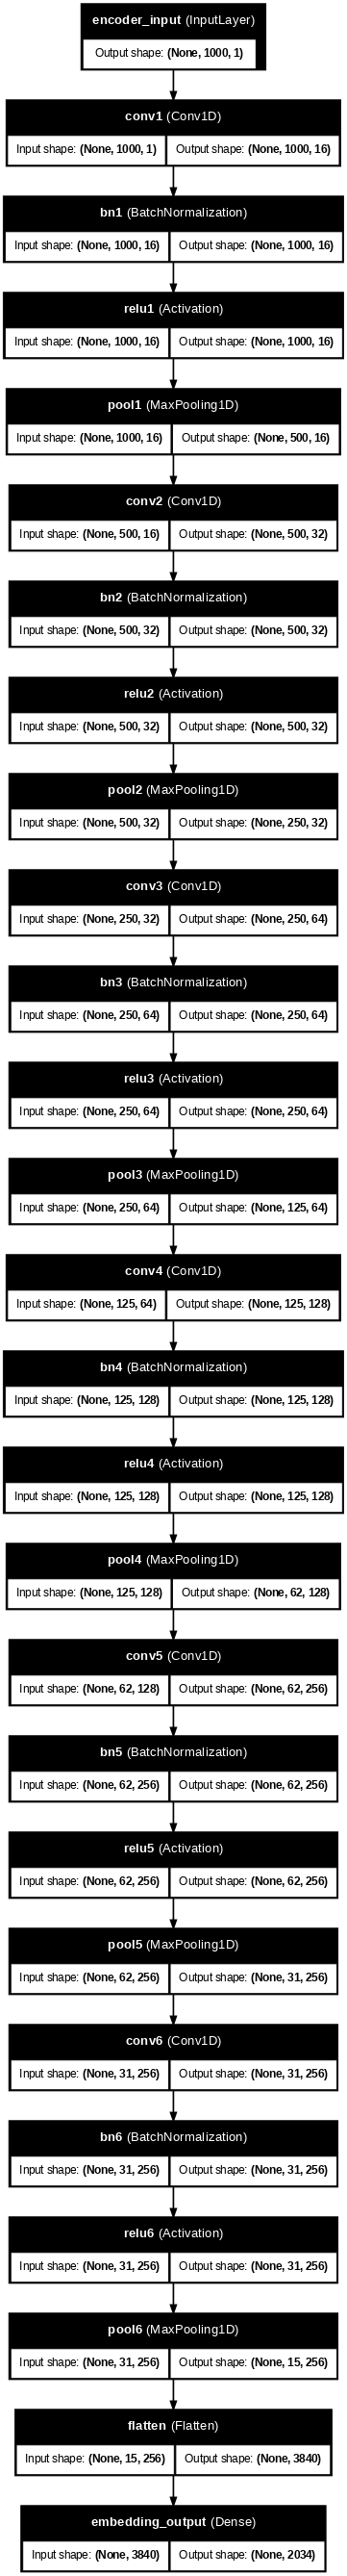

In [16]:

#Plot model ( pydot and graphviz )
tf.keras.utils.plot_model(cnn_encoder_updated, show_shapes=True, show_layer_names=True, dpi=60)

# triplet_generator

In [17]:

# These variables should be populated from your successful preprocessing cell:
# X_data_cnn: NumPy array of shape (1920, 1000, 1)
# source_ids: List of 1920 tuples, e.g., [('Person_01', 'rec_1'), ('Person_01', 'rec_1'), ...]

print(f"Using X_data_cnn with shape: {X_data_cnn.shape}")
print(f"Using source_ids list with length: {len(source_ids)}")

# Group segments by their source_id for easier positive pair sampling
segments_by_source = {}
for i, src_id in enumerate(source_ids): # Use the globally updated 'source_ids'
    # src_id is a tuple like ('Person_01', 'rec_1')
    # Make sure src_id is hashable (tuples are)
    if src_id not in segments_by_source:
        segments_by_source[src_id] = []
    segments_by_source[src_id].append(i) # Store indices of segments

# Remove sources with only one segment, as they can't form positive pairs for triplets
sources_for_triplets = {src: idx_list for src, idx_list in segments_by_source.items() if len(idx_list) >= 2}
list_of_source_keys = list(sources_for_triplets.keys())

print(f"\nNumber of unique source_ids (Person, Record pairs): {len(segments_by_source)}")
print(f"Number of sources with >= 2 segments (usable for triplets): {len(sources_for_triplets)}")

if len(sources_for_triplets) < 2: # Need at least two distinct (Person,Record) pairs that can provide an Anchor/Positive
    print("CRITICAL: Not enough diverse sources to form triplets effectively. ")
    print("           Need at least 2 different (Person,Record) pairs, each with >=2 segments.")
    print("           Training may not be meaningful. Consider processing even more data from more persons.")
    train_generator = None
elif not list_of_source_keys: # Should be covered by above, but good to be safe
     print("CRITICAL: list_of_source_keys is empty. Cannot proceed with triplet generation.")
     train_generator = None
else:
    # Define the triplet_generator function (copy from previous response if not in a cell above)
    def triplet_generator(X_data_input, source_ids_map_input, list_of_sources_input, batch_size_input):
        while True:
            anchors_idx, positives_idx, negatives_idx = [], [], []
            for _ in range(batch_size_input):
                if not list_of_sources_input: break # Should not happen if initial checks pass

                anchor_source_id = random.choice(list_of_sources_input)
                # Ensure the chosen anchor_source_id actually has >= 2 segments in the map
                if len(source_ids_map_input.get(anchor_source_id, [])) < 2:
                    # This source became invalid somehow (should not happen with current logic but defensive)
                    # Or, if list_of_sources_input was not filtered properly.
                    # Let's try to pick another one or skip this iteration.
                    continue 
                anchor_idx, positive_idx = random.sample(source_ids_map_input[anchor_source_id], 2)

                negative_source_id = random.choice(list_of_sources_input)
                max_retries, retry_count = 10, 0
                while negative_source_id == anchor_source_id and len(list_of_sources_input) > 1 and retry_count < max_retries:
                    negative_source_id = random.choice(list_of_sources_input)
                    retry_count += 1
                
                # Ensure the chosen negative_source_id is valid and has segments
                if not source_ids_map_input.get(negative_source_id, []):
                    continue # Skip if no segments for chosen negative source

                negative_idx = random.choice(source_ids_map_input[negative_source_id])

                anchors_idx.append(anchor_idx)
                positives_idx.append(positive_idx)
                negatives_idx.append(negative_idx)
            
            if not anchors_idx: continue # If loop above didn't add any, try batch again

            batch_anchors = X_data_input[anchors_idx]
            batch_positives = X_data_input[positives_idx]
            batch_negatives = X_data_input[negatives_idx]
            yield (batch_anchors, batch_positives, batch_negatives), np.zeros((len(anchors_idx), 1))

    BATCH_SIZE = 16 # Can try a slightly larger batch size now, e.g., 16 or 32
                    # Total data = 1920. 1920/16 = 120 batches if all data used once.
    train_generator = triplet_generator(X_data_cnn, sources_for_triplets, list_of_source_keys, BATCH_SIZE)
    
    # Test the generator for one batch
    print(f"\nTriplet generator created with BATCH_SIZE = {BATCH_SIZE}")
    try:
        [sample_anchors, sample_positives, sample_negatives], _ = next(train_generator)
        print("Successfully generated one batch of triplets:")
        print("  Sample Anchor shape:", sample_anchors.shape)
        print("  Sample Positive shape:", sample_positives.shape)
        print("  Sample Negative shape:", sample_negatives.shape)
    except StopIteration:
        print("ERROR: Triplet generator did not yield any data. Check data diversity and generator logic.")
        train_generator = None # Mark as unusable
    except Exception as e:
        print(f"ERROR testing triplet generator: {e}")
        train_generator = None



Using X_data_cnn with shape: (6372, 1000, 1)
Using source_ids list with length: 6372

Number of unique source_ids (Person, Record pairs): 310
Number of sources with >= 2 segments (usable for triplets): 310

Triplet generator created with BATCH_SIZE = 16
Successfully generated one batch of triplets:
  Sample Anchor shape: (16, 1000, 1)
  Sample Positive shape: (16, 1000, 1)
  Sample Negative shape: (16, 1000, 1)


# Define PCC Similarity, Triplet Network, and Loss Function

In [18]:
import tensorflow as tf # Make sure tf is imported
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Lambda, Layer # Add Layer for completeness if needed elsewhere
from tensorflow.keras.models import Model

# ... (ALPHA_MARGIN and pcc_similarity function remain the same) ...
ALPHA_MARGIN = 0.7

def pcc_similarity(tensors):
    emb1, emb2 = tensors
    mean1 = K.mean(emb1, axis=-1, keepdims=True)
    mean2 = K.mean(emb2, axis=-1, keepdims=True)
    centered1 = emb1 - mean1
    centered2 = emb2 - mean2
    covariance = K.sum(centered1 * centered2, axis=-1)
    stddev1 = K.sqrt(K.sum(K.square(centered1), axis=-1))
    stddev2 = K.sqrt(K.sum(K.square(centered2), axis=-1))
    pcc = covariance / (stddev1 * stddev2 + K.epsilon())
    return pcc

# --- Assume cnn_encoder_updated is defined from the previous cell ---
# --- Assume SEGMENT_SAMPLES is defined ---
SEGMENT_SAMPLES = 1000 # ensure it's defined

input_anchor = Input(shape=(SEGMENT_SAMPLES, 1), name="anchor_input")
input_positive = Input(shape=(SEGMENT_SAMPLES, 1), name="positive_input")
input_negative = Input(shape=(SEGMENT_SAMPLES, 1), name="negative_input")

embedding_anchor = cnn_encoder_updated(input_anchor)
embedding_positive = cnn_encoder_updated(input_positive)
embedding_negative = cnn_encoder_updated(input_negative)

pcc_ap = Lambda(pcc_similarity, name="pcc_anchor_positive")([embedding_anchor, embedding_positive])
pcc_an = Lambda(pcc_similarity, name="pcc_anchor_negative")([embedding_anchor, embedding_negative])

# --- MODIFICATION HERE ---
# Wrap tf.stack in a Lambda layer
def stack_pccs_fn(inputs): # Define a helper function for the Lambda layer
    pcc1, pcc2 = inputs
    return tf.stack([pcc1, pcc2], axis=1)

stacked_pccs = Lambda(stack_pccs_fn, name="stacked_pcc_similarities")([pcc_ap, pcc_an])
# --- END MODIFICATION ---


triplet_network = Model(inputs=[input_anchor, input_positive, input_negative], 
                        outputs=stacked_pccs, 
                        name="triplet_network")

triplet_network.summary() # Good to check the summary after this change

def triplet_loss_pcc(y_true, y_pred_stacked_pccs):
    pcc_ap = y_pred_stacked_pccs[:, 0]
    pcc_an = y_pred_stacked_pccs[:, 1]
    loss = K.maximum(0.0, ALPHA_MARGIN - (pcc_ap - pcc_an))
    return K.mean(loss)

print("\nPCC similarity, Triplet Network, and Loss function defined (with tf.stack wrapped in Lambda).")

Model: "triplet_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ anchor_input (InputLayer) │ (None, 1000, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positive_input            │ (None, 1000, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ negative_input            │ (None, 1000, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_encoder_fig4          │ (None, 2034)           │      8,292,050 │ anchor_input[0][0],    │
│ (Functional)              │                        │                │ positive_input[0][0],  │
│                           │                        │                │ negative_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pcc_anchor_positive       │ (None)                 │              0 │ cnn_encoder_fig4[0][0… │
│ (Lambda)                  │                        │                │ cnn_encoder_fig4[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pcc_anchor_negative       │ (None)                 │              0 │ cnn_encoder_fig4[0][0… │
│ (Lambda)                  │                        │                │ cnn_encoder_fig4[2][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stacked_pcc_similarities  │ (None, 2)              │              0 │ pcc_anchor_positive[0… │
│ (Lambda)                  │                        │                │ pcc_anchor_negative[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,292,050 (31.63 MB)

 Trainable params: 8,290,546 (31.63 MB)

 Non-trainable params: 1,504 (5.88 KB)


PCC similarity, Triplet Network, and Loss function defined (with tf.stack wrapped in Lambda).


# Compile and Train

Triplet network compiled (or already compiled).

Starting training with BATCH_SIZE=16, EPOCHS=200, STEPS_PER_EPOCH=199
Using pre-existing Python train_generator instance to create tf.data.Dataset (less common).
tf.data.Dataset created successfully from generator using a callable.
Epoch 1/200


I0000 00:00:1749187769.005673     120 service.cc:148] XLA service 0x7f50f4002a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749187769.006502     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749187770.039871     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


 21/199 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3284

I0000 00:00:1749187776.282162     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/199 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.2118
Epoch 2/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1218
Epoch 3/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1131
Epoch 4/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0941
Epoch 5/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0929
Epoch 6/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0907
Epoch 7/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0769
Epoch 8/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0898
Epoch 9/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0769
Epoch 10/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0790
Epoch 11/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0760
Epoch 12/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0688
Epoch 13/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0622
Epoch 14/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0695
Epoch 15/200
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

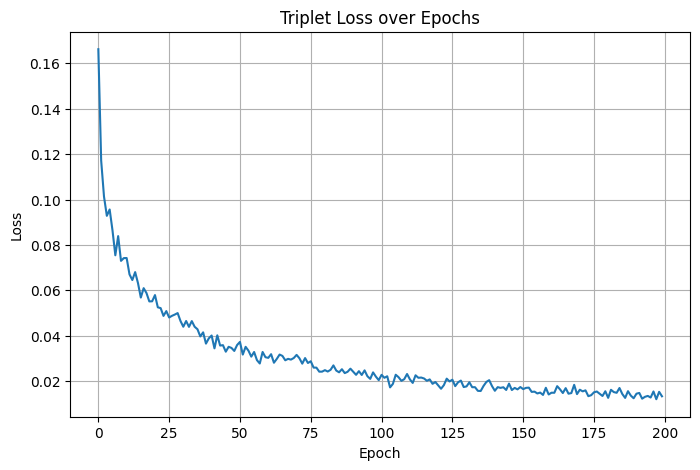

In [19]:
import tensorflow as tf # Ensure tf is imported
import numpy as np    # Ensure np is imported
import matplotlib.pyplot as plt # For plotting


# Optimizer (ensure it's defined, e.g., from previous cell)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005) 
triplet_network.compile(optimizer=optimizer, loss=triplet_loss_pcc) # This should have been done

print("Triplet network compiled (or already compiled).")

# --- Training ---
EPOCHS = 200
if X_data_cnn.size > 0 and len(sources_for_triplets) > 1 :
    STEPS_PER_EPOCH = max(1, int(len(X_data_cnn) / BATCH_SIZE / 2)) 
    if STEPS_PER_EPOCH < 10:
        STEPS_PER_EPOCH = min(10, int(len(X_data_cnn) / BATCH_SIZE) if BATCH_SIZE > 0 else 10)
    
    print(f"\nStarting training with BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}, STEPS_PER_EPOCH={STEPS_PER_EPOCH}")

    # --- MODIFICATION: Create tf.data.Dataset from the generator ---
    # Define the output signature based on what your triplet_generator yields
    # It yields: ([batch_anchors, batch_positives, batch_negatives], np.zeros((len(anchors_idx), 1)))
    # Shapes:
    #   batch_anchors: (BATCH_SIZE, SEGMENT_SAMPLES, 1)
    #   batch_positives: (BATCH_SIZE, SEGMENT_SAMPLES, 1)
    #   batch_negatives: (BATCH_SIZE, SEGMENT_SAMPLES, 1)
    #   dummy_labels: (BATCH_SIZE, 1)
    # Dtypes:
    #   All segment data is likely tf.float32 (Keras default)
    #   Dummy labels can be tf.float32 or tf.int32

    # Ensure SEGMENT_SAMPLES is defined
    if 'SEGMENT_SAMPLES' not in locals():
        SEGMENT_SAMPLES = 1000 # Define if somehow missing

    output_sig = (
        ( # This tuple corresponds to the first element yielded by the generator: [A, P, N]
            tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32), # Anchor
            tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32), # Positive
            tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32)  # Negative
        ), 
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32) # This corresponds to the dummy labels
    )

    # Create the tf.data.Dataset
    # Make sure your triplet_generator function is defined correctly
    # and accessible here.
    # Also ensure all its arguments (X_data_cnn, sources_for_triplets, etc.) are correctly passed.
    
    # Re-check if train_generator (the Python generator instance) was successfully created
    if 'train_generator' not in locals() or train_generator is None:
        # Attempt to recreate the Python generator instance if it was not created or set to None
        print("Python train_generator instance not found or was None, attempting to recreate...")
        if len(sources_for_triplets) >= 1 and \
           (len(sources_for_triplets) > 1 or \
            (list_of_source_keys and len(sources_for_triplets.get(list_of_source_keys[0], [])) >= BATCH_SIZE*2 ) ):
            
            # Make sure triplet_generator function is defined before this line
            # def triplet_generator(X_data_input, source_ids_map_input, list_of_sources_input, batch_size_input): ...
            
            py_train_generator_fn = lambda: triplet_generator(
                X_data_cnn, sources_for_triplets, list_of_source_keys, BATCH_SIZE
            )
            tf_train_dataset = tf.data.Dataset.from_generator(
                py_train_generator_fn, # Pass the function that creates the generator
                output_signature=output_sig
            )
            print("tf.data.Dataset created successfully from generator.")
        else:
            print("Still not enough data/diversity to create a robust Python generator for tf.data.Dataset.")
            tf_train_dataset = None
    else:
        # If train_generator (the Python generator instance) already exists and is valid
        # (This path might not be hit if you only create the instance once)
        print("Using pre-existing Python train_generator instance to create tf.data.Dataset (less common).")
        # This direct use of an already instantiated generator is sometimes tricky with from_generator.
        # It's often better to pass a callable that *returns* a new generator instance.
        # Let's stick to the callable approach above.
        py_train_generator_fn = lambda: triplet_generator( # Define the callable
            X_data_cnn, sources_for_triplets, list_of_source_keys, BATCH_SIZE
        )
        tf_train_dataset = tf.data.Dataset.from_generator(
            py_train_generator_fn,
            output_signature=output_sig
        )
        print("tf.data.Dataset created successfully from generator using a callable.")


    if tf_train_dataset:
        # Optional: Prefetch for performance
        tf_train_dataset = tf_train_dataset.prefetch(tf.data.AUTOTUNE)

        history = triplet_network.fit(
            tf_train_dataset, # Pass the tf.data.Dataset object
            epochs=EPOCHS,
            steps_per_epoch=STEPS_PER_EPOCH, # STEPS_PER_EPOCH should still be defined
            verbose=1
        )
        print("\nTraining finished.")
        
        if 'loss' in history.history:
            plt.figure(figsize=(8,5))
            plt.plot(history.history['loss'])
            plt.title('Triplet Loss over Epochs')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.grid(True)
            plt.show()
        else:
            print("No 'loss' key in history.history. Cannot plot loss.")
    else:
        print("tf.data.Dataset could not be created. Cannot start training.")
        
else:
    print("\nNot enough processed data or source diversity to start training the triplet network.")
    # ... (rest of the error message as before) ...

# Saving for future


In [20]:

cnn_encoder_updated.save_weights('trained_cnn_encoder_weights.weights.h5') 
# save the whole model if you prefer, though for inference we just need the encoder
cnn_encoder_updated.save('trained_cnn_encoder_model.keras')
print("Trained CNN encoder weights saved.")

Trained CNN encoder weights saved.


In [21]:

# fresh_encoder = build_cnn_encoder_fig4(input_shape=(SEGMENT_SAMPLES, 1), embedding_dim=2034)
# fresh_encoder.load_weights('trained_cnn_encoder_weights.weights.h5')

# AUTHENTICATION

In [22]:

NUM_REGISTERED_PERSONS = 60 
NUM_REG_SEGMENTS_PER_PERSON_DB = 10 
AUTHENTICATION_THRESHOLD = ALPHA_MARGIN

# --- 1. Split Data into Registered, Unregistered, and Test Sets ---

# Get unique person IDs
unique_person_ids = sorted(list(set([src[0] for src in source_ids])))
print(f"\nTotal unique persons processed: {len(unique_person_ids)}")

if len(unique_person_ids) < NUM_REGISTERED_PERSONS:
    print(f"WARNING: Not enough unique persons ({len(unique_person_ids)}) to register {NUM_REGISTERED_PERSONS}.")
    NUM_REGISTERED_PERSONS = len(unique_person_ids)
    print(f"Adjusted NUM_REGISTERED_PERSONS to {NUM_REGISTERED_PERSONS}.")

# Randomly select registered person IDs
registered_person_ids = random.sample(unique_person_ids, NUM_REGISTERED_PERSONS)
unregistered_person_ids = [pid for pid in unique_person_ids if pid not in registered_person_ids]

print(f"Registered persons ({len(registered_person_ids)}): {registered_person_ids}")
print(f"Unregistered persons ({len(unregistered_person_ids)}): {unregistered_person_ids}")


# Separate segments based on person ID and whether they are for DB or testing
registered_db_segments_indices = [] # Indices in X_data_cnn for registered user DB
test_segments_indices = []          # Indices in X_data_cnn for test set
test_source_ids = []              # source_ids corresponding to test_segments_indices

# Keep track of segments added to DB for each registered person
reg_segments_count = {}

for i, (segment, src_id) in enumerate(zip(X_data_cnn, source_ids)):
    person_id = src_id[0]

    if person_id in registered_person_ids:
        # This segment is from a registered person
        if person_id not in reg_segments_count:
             reg_segments_count[person_id] = 0

        if reg_segments_count[person_id] < NUM_REG_SEGMENTS_PER_PERSON_DB:
            # Use the first NUM_REG_SEGMENTS_PER_PERSON_DB segments for the DB
            registered_db_segments_indices.append(i)
            reg_segments_count[person_id] += 1
        else:
            # Use subsequent segments from this registered person for testing (True Positives)
            test_segments_indices.append(i)
            test_source_ids.append(src_id) # Store the source ID for ground truth
    else:
        # This segment is from an unregistered person (True Negatives / Impostors)
        test_segments_indices.append(i)
        test_source_ids.append(src_id) # Store the source ID for ground truth


X_reg_db = X_data_cnn[registered_db_segments_indices]
X_test = X_data_cnn[test_segments_indices]

print(f"\nTotal segments for registered user database: {len(registered_db_segments_indices)}")
print(f"Total segments for testing: {len(test_segments_indices)}")
print(f"Shape of X_reg_db: {X_reg_db.shape}")
print(f"Shape of X_test: {X_test.shape}")


# Map source IDs to indices for the registered DB segments
# We need to know which person each DB segment belongs to
reg_db_source_ids = [source_ids[i] for i in registered_db_segments_indices]
# Group DB segments by person ID for easy lookup during authentication
registered_user_db_features = {} # Key: person_id_str, Value: list of feature vectors

# --- 2. Build Registered User Database (Feature Vectors) ---
print("\nBuilding registered user database by running DB segments through the trained encoder...")
# Predict features in batches for efficiency
batch_size_inference = 64 # Use a larger batch size for inference if memory allows

# Note: encoder.predict returns numpy arrays
db_features = cnn_encoder_updated.predict(X_reg_db, batch_size=batch_size_inference)

# Store features grouped by person ID
for i, src_id in enumerate(reg_db_source_ids):
    person_id = src_id[0]
    if person_id not in registered_user_db_features:
        registered_user_db_features[person_id] = []
    # Store the feature vector (shape (embedding_dim,))
    registered_user_db_features[person_id].append(db_features[i])

print(f"Database built for {len(registered_user_db_features)} registered persons.")

def calculate_pcc_numpy(emb1, emb2):
    """
    Calculates Pearson Correlation Coefficient between two numpy arrays.
    Handles single vectors (1D) or batches (2D).
    """
    # Ensure inputs are numpy arrays and have compatible dimensions
    emb1 = np.asarray(emb1)
    emb2 = np.asarray(emb2)

    if emb1.ndim == 1: emb1 = emb1[np.newaxis, :] # Make 1D -> 2D batch of 1
    if emb2.ndim == 1: emb2 = emb2[np.newaxis, :]

    if emb1.shape[-1] != emb2.shape[-1]:
        raise ValueError("Last dimension of embeddings must match for PCC calculation")
        
    # This numpy implementation mimics the Keras backend logic
    mean1 = np.mean(emb1, axis=-1, keepdims=True)
    mean2 = np.mean(emb2, axis=-1, keepdims=True)
    centered1 = emb1 - mean1
    centered2 = emb2 - mean2
    
    # Covariance: sum over last dimension
    covariance = np.sum(centered1 * centered2, axis=-1)
    
    # Standard deviations: sqrt of sum of squares over last dimension
    stddev1 = np.sqrt(np.sum(np.square(centered1), axis=-1))
    stddev2 = np.sqrt(np.sum(np.square(centered2), axis=-1))
    
    # PCC calculation, add epsilon for numerical stability
    # K.epsilon() is usually 1e-7 in TensorFlow. Use a small number.
    epsilon = 1e-7
    denominator = stddev1 * stddev2 + epsilon
    pcc = covariance / denominator
    
    # If inputs were originally 1D, return a scalar; otherwise, return the batch results
    if emb1.shape[0] == 1 and emb2.shape[0] == 1:
        return pcc[0] # Return scalar if single vectors were compared
    else:
        return pcc # Return batch results


def authenticate_segment(test_segment, registered_db_features, encoder, threshold):
    """
    Authenticates a single test ECG segment against the registered user database.

    Args:
        test_segment (numpy.ndarray): The preprocessed, normalized ECG segment
                                     (shape: (SEGMENT_SAMPLES, 1)).
        registered_db_features (dict): Database {person_id: [feature_vector1, ...], ...}.
                                     Feature vectors are numpy arrays.
        encoder (tf.keras.Model): The trained CNN encoder model.
        threshold (float): The authentication threshold (PCC similarity).

    Returns:
        tuple: (is_authenticated, max_similarity_score, predicted_person_id)
               is_authenticated (bool): True if authentication is successful.
               max_similarity_score (float): The highest PCC score found.
               predicted_person_id (str or None): The ID of the user with the max score,
                                                 or None if no users in DB.
    """
    if not registered_db_features:
        return False, -np.inf, None # No registered users

    # 1. Get feature vector for the test segment
    # Need to add batch dimension for prediction
    test_segment_input = np.expand_dims(test_segment, axis=0) # Shape (1, SEGMENT_SAMPLES, 1)
    test_features = encoder.predict(test_segment_input, verbose=0) # Shape (1, embedding_dim)
    test_features = test_features[0] # Remove batch dim, shape (embedding_dim,)

    # 2. Compare against all stored features in the database
    max_similarity = -np.inf
    predicted_person_id = None

    for person_id, stored_features_list in registered_db_features.items():
        # stored_features_list is a list of numpy arrays, each shape (embedding_dim,)
        
        # Calculate PCC of the test_features (1,) against ALL stored_features for this person (N, embedding_dim)
        # To use calculate_pcc_numpy effectively, stack the stored features for this person
        stacked_stored_features = np.vstack(stored_features_list) # Shape (NumStoredForPerson, embedding_dim)
        
        # Calculate PCC between the single test feature vector and the stacked stored features
        # Need to reshape test_features to (1, embedding_dim) for calculate_pcc_numpy batch processing
        similarities = calculate_pcc_numpy(test_features[np.newaxis, :], stacked_stored_features) # Shape (NumStoredForPerson,)
        
        # Find the maximum similarity score for this person
        max_sim_this_person = np.max(similarities)

        # Update overall max similarity and the corresponding person ID
        if max_sim_this_person > max_similarity:
            max_similarity = max_sim_this_person
            predicted_person_id = person_id

    # 3. Make authentication decision
    is_authenticated = max_similarity > threshold

    return is_authenticated, max_similarity, predicted_person_id




Total unique persons processed: 90
Registered persons (60): ['Person_54', 'Person_89', 'Person_34', 'Person_44', 'Person_73', 'Person_48', 'Person_29', 'Person_36', 'Person_63', 'Person_68', 'Person_35', 'Person_88', 'Person_70', 'Person_64', 'Person_81', 'Person_77', 'Person_22', 'Person_55', 'Person_56', 'Person_57', 'Person_49', 'Person_03', 'Person_09', 'Person_40', 'Person_58', 'Person_32', 'Person_33', 'Person_67', 'Person_51', 'Person_52', 'Person_17', 'Person_38', 'Person_69', 'Person_43', 'Person_74', 'Person_42', 'Person_07', 'Person_86', 'Person_71', 'Person_66', 'Person_65', 'Person_10', 'Person_02', 'Person_84', 'Person_06', 'Person_04', 'Person_47', 'Person_75', 'Person_13', 'Person_14', 'Person_50', 'Person_78', 'Person_37', 'Person_23', 'Person_08', 'Person_01', 'Person_05', 'Person_85', 'Person_25', 'Person_24']
Unregistered persons (30): ['Person_11', 'Person_12', 'Person_15', 'Person_16', 'Person_18', 'Person_19', 'Person_20', 'Person_21', 'Person_26', 'Person_27', 

In [23]:

# --- 4. Evaluate the System ---

print(f"\nEvaluating authentication performance on {len(test_segments_indices)} test segments...")
# Metrics
TP, TN, FP, FN = 0, 0, 0, 0

# Iterate through the test segments
for i, test_segment in enumerate(X_test):
    true_source_id = test_source_ids[i]
    true_person_id = true_source_id[0]

    # Determine the ground truth: Is this segment from a registered user?
    is_true_registered = true_person_id in registered_person_ids

    # Perform authentication using the developed function
    is_authenticated, max_sim_score, predicted_person_id = authenticate_segment(
        test_segment, registered_user_db_features, cnn_encoder_updated, AUTHENTICATION_THRESHOLD
    )

    # Compare prediction to ground truth and update counts
    if is_true_registered:
        # This is a True Positive case if authenticated
        if is_authenticated:
            TP += 1
        else:
            FN += 1 # Failed to authenticate a legitimate user (False Negative)
    else:
        # This is a True Negative case if NOT authenticated
        if is_authenticated:
            FP += 1 # Incorrectly authenticated an unregistered user (False Positive)
        else:
            TN += 1


print("\nEvaluation Complete.")
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

# Calculate final metrics
# Precision = TP / (TP + FP)  (Out of accepted users, how many were correct?)
# Recall = TP / (TP + FN)     (Out of true registered users, how many were accepted?)
# Accuracy = (TP + TN) / (TP + TN + FP + FN) (Overall correct decisions)
# FAR = FP / (TN + FP)        (Out of true unregistered users, how many were falsely accepted?) - False Acceptance Rate
# FRR = FN / (TP + FN)        (Out of true registered users, how many were falsely rejected?) - False Rejection Rate

total_tests = TP + TN + FP + FN
accuracy = (TP + TN) / total_tests if total_tests > 0 else 0

# Precision is usually calculated from the perspective of positive *predictions*
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
# Recall (TPR) is from the perspective of true *positives* (registered users)
recall_tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
# FPR is from the perspective of true *negatives* (unregistered users)
fpr_far = FP / (TN + FP) if (TN + FP) > 0 else 0
# FRR is from the perspective of true *positives* (registered users)
frr = FN / (TP + FN) if (TP + FN) > 0 else 0 # Note: recall_tpr = 1 - frr

# F1 Score (Harmonic mean of Precision and Recall)
f1_score = 2 * (precision * recall_tpr) / (precision + recall_tpr) if (precision + recall_tpr) > 0 else 0


print("\n--- Authentication Metrics ---")
print(f"Configuration:")
print(f"  Registered Persons: {NUM_REGISTERED_PERSONS}")
print(f"  DB Segments per Registered Person: {NUM_REG_SEGMENTS_PER_PERSON_DB} (approx, using first available)")
print(f"  Authentication Threshold (PCC): {AUTHENTICATION_THRESHOLD:.4f}")
print(f"  Total Test Segments: {total_tests}")
print(f"    True Registered Tests (should be accepted): {TP + FN}")
print(f"    True Unregistered Tests (should be rejected): {TN + FP}")


print(f"\nResults:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (TPR): {recall_tpr:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"False Acceptance Rate (FAR / FPR): {fpr_far:.4f}")
print(f"False Rejection Rate (FRR): {frr:.4f}")

# Note: For authentication, FAR and FRR are often the most critical metrics.
# A low FAR means few impostors get in. A low FRR means few legitimate users are locked out.
# Ideally, you want to find a threshold where FAR and FRR are balanced (EER - Equal Error Rate).
# Your initial threshold is based on the training margin. You might need to adjust it.
# The paper's Figure 8 shows plotting FAR/FRR vs threshold to find the optimal point.


Evaluating authentication performance on 5772 test segments...

Evaluation Complete.
TP: 2818, TN: 1211, FP: 756, FN: 987

--- Authentication Metrics ---
Configuration:
  Registered Persons: 60
  DB Segments per Registered Person: 10 (approx, using first available)
  Authentication Threshold (PCC): 0.7000
  Total Test Segments: 5772
    True Registered Tests (should be accepted): 3805
    True Unregistered Tests (should be rejected): 1967

Results:
Accuracy: 0.6980
Precision: 0.7885
Recall (TPR): 0.7406
F1 Score: 0.7638
False Acceptance Rate (FAR / FPR): 0.3843
False Rejection Rate (FRR): 0.2594


In [ ]:


print(f"\nEvaluating authentication performance on {len(X_test)} test segments...")

# --- Data Collection for Plotting ---
# Initialize lists to store scores based on ground truth
genuine_scores = []
impostor_scores = []

# Metrics (keep these as well)
TP, TN, FP, FN = 0, 0, 0, 0

# Iterate through the test segments
# Use tqdm for a progress bar if you have it installed (pip install tqdm)
# from tqdm.notebook import tqdm
# for i, test_segment in enumerate(tqdm(X_test, desc="Authenticating test segments")):

for i, test_segment in enumerate(X_test):
    true_source_id = test_source_ids[i]
    true_person_id = true_source_id[0]

    # Determine the ground truth: Is this segment from a registered user?
    is_true_registered = true_person_id in registered_person_ids

    # Perform authentication using the developed function
    # This function already returns max_similarity_score
    # Ensure authenticate_segment function is defined before this cell
    is_authenticated, max_sim_score, predicted_person_id = authenticate_segment(
        test_segment, registered_user_db_features, cnn_encoder_updated, AUTHENTICATION_THRESHOLD
    )

    # --- Store the score for plotting ---
    if is_true_registered:
        genuine_scores.append(max_sim_score)
        # Update metrics based on authentication decision
        if is_authenticated:
            TP += 1
        else:
            FN += 1
    else: # Segment is from an unregistered user (impostor)
        impostor_scores.append(max_sim_score)
        # Update metrics based on authentication decision
        if is_authenticated:
            FP += 1
        else:
            TN += 1

# After the loop, genuine_scores and impostor_scores lists are populated


print("\nEvaluation Complete.")
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")


# --- Calculate final metrics (keep these as they are) ---
total_tests = TP + TN + FP + FN
accuracy = (TP + TN) / total_tests if total_tests > 0 else 0

# Check for division by zero in precision, recall, FAR, FRR
# Precision = TP / (TP + FP)  (Out of accepted users, how many were correct?)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
# Recall (TPR) = TP / (TP + FN)     (Out of true registered users, how many were accepted?)
true_registered_count = TP + FN
recall_tpr = TP / true_registered_count if true_registered_count > 0 else 0
# FPR = FP / (TN + FP)        (Out of true unregistered users, how many were falsely accepted?) - False Acceptance Rate
true_unregistered_count = TN + FP
fpr_far = FP / true_unregistered_count if true_unregistered_count > 0 else 0
# FRR = FN / (TP + FN)        (Out of true registered users, how many were falsely rejected?) - False Rejection Rate
frr = FN / true_registered_count if true_registered_count > 0 else 0 # Note: recall_tpr = 1 - frr

# F1 Score (Harmonic mean of Precision and Recall)
f1_score = 2 * (precision * recall_tpr) / (precision + recall_tpr) if (precision + recall_tpr) > 0 else 0


print("\n--- Authentication Metrics ---")
print(f"Configuration:")
print(f"  Registered Persons: {NUM_REGISTERED_PERSONS}")
print(f"  DB Segments per Registered Person: {NUM_REG_SEGMENTS_PER_PERSON_DB} (approx, using first available)")
print(f"  Authentication Threshold (PCC): {AUTHENTICATION_THRESHOLD:.4f}")
print(f"  Total Test Segments: {total_tests}")
print(f"    True Registered Tests (should be accepted): {true_registered_count}")
print(f"    True Unregistered Tests (should be rejected): {true_unregistered_count}")


print(f"\nResults:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (TPR): {recall_tpr:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"False Acceptance Rate (FAR / FPR): {fpr_far:.4f}")
print(f"False Rejection Rate (FRR): {frr:.4f}")


# --- Plotting Score Distributions ---
print("\nPlotting score distributions...")

plt.figure(figsize=(10, 6))

# Use common bins for both histograms to align them
# PCC range is -1 to 1. Let's create bins across this range.
# Adjust the number of bins if needed for more detail
bins = np.linspace(-1.0, 1.0, 100) # 100 bins from -1 to 1

# Plot Genuine Scores histogram
# density=True ensures the area sums to 1, allowing comparison of shapes
plt.hist(genuine_scores, bins=bins, color='green', alpha=0.7, density=True, label='Genuine Scores')

# Plot Impostor Scores histogram
plt.hist(impostor_scores, bins=bins, color='red', alpha=0.7, density=True, label='Impostor Scores (Max against any template)')

# Add the authentication threshold line
plt.axvline(x=AUTHENTICATION_THRESHOLD, color='blue', linestyle='--', linewidth=2, label=f'Threshold $\lambda={AUTHENTICATION_THRESHOLD:.2f}$')

plt.title('Score Distributions for Genuine and Impostor Attempts')
plt.xlabel('Pearson Correlation Coefficient (PCC)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()